# CSCI 6405 - João Pimentel [B00946602] - Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import plotnine as p9
import re
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_white
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from patsy import dmatrices
from pmdarima.arima import ndiffs, nsdiffs

### Data loading and initial exploration

In [3]:
train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')

We see that the training dataset contains 5087 rows and 3198 columns.

In [4]:
train.shape

(5087, 3198)

There are 5050 rows with label = 1 (no exoplanets) and only 37 with label = 2 (detected exoplanets) on the training data set.

In [5]:
train.LABEL.value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

There are 565 rows with label = 1 (no exoplanets) and only 5 with label = 2 (detected exoplanets) on the testing data set.

In [6]:
test.LABEL.value_counts()

1    565
2      5
Name: LABEL, dtype: int64

In total, there are 5615 rows with label = 1 (no exoplanets) and only 42 with label = 2 (detected exoplanets).

In [7]:
pd.concat([train, test]).LABEL.value_counts()

1    5615
2      42
Name: LABEL, dtype: int64

Each row contains a label value and 3197 flux measurements, each representing a different time step, i.e., flux.N, where N is the time step.

In [31]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


We see that there is not a single null value on the training data.

In [17]:
train.isna().sum().sum()

0

The same goes for the testing data.

In [18]:
test.isna().sum().sum()

0

### Graphical exploration

##### Stars without exoplanets in orbit

First, we selected 5 random rows that are characterized by not containing exoplanets in orbit (label = 1).

In [94]:
random_training_samples = train.loc[train['LABEL'] == 1, :].copy() \
  .sample(n = 5) \
  .drop(columns = ['LABEL']) \
  .reset_index(level = 0) \
  .melt(id_vars = ['index'])

random_training_samples['index'] = random_training_samples['index'].astype('category')
random_training_samples['variable'] = pd.to_numeric(random_training_samples['variable'].apply(lambda x : re.sub('FLUX\\.', '', x)))

The line plot, with flux values plotted over time, for the randomly selected stars without exoplanets does not show a clear pattern, as star 1529 appears to show some level of seasonality, contrarily to the stars 647, 2307 and 2636 that show an uniform range of values with some punctual spikes. Additionally, star 3340 shows a regular dimming pattern in flux, followed by a mirroring increase, which would be expected from a star with exoplanets, which is not the case.

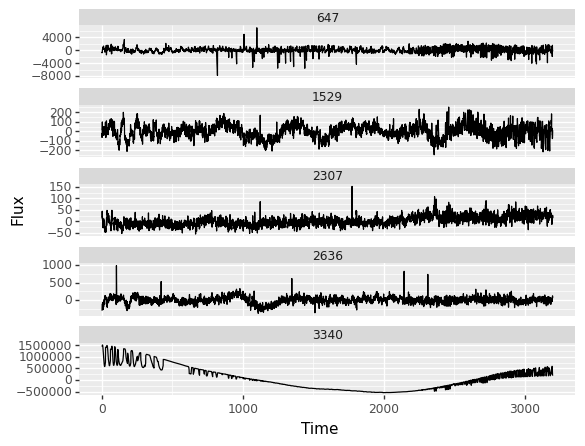

<ggplot: (950180979)>

In [101]:
p9.ggplot(random_training_samples,
  p9.aes(x = 'variable', y = 'value', group = 'index')
  ) + \
  p9.theme_gray() + \
  p9.geom_line() + \
  p9.xlab('Time') + \
  p9.ylab('Flux') + \
  p9.facet_wrap(facets = '~index', ncol = 1, scales = 'free_y') + \
  p9.theme(
    legend_title = p9.element_blank(),
    legend_position = 'bottom'
  )

In order to try to understand how the flux values are distributed, histogram representations of flux where are also plotted for the same stars. We see that stars 647 and 2636 show normal-like distributions, while the distribution of stars 1529 and 2307 show the values distributed over a wider range of values, with the latter showing some signs of positive skewness. All four of these distributions appear to share one aspect in common, all are centred around 0 flux. Star 3340 shows a distributions of values in an even wider range of values, which was to be expected due to how the values behave over time. Nonetheless, its behaviour is extremely different from the other four randomly selected stars without exoplanets.
Once more, there is not a clearly defined pattern within this subset of data.

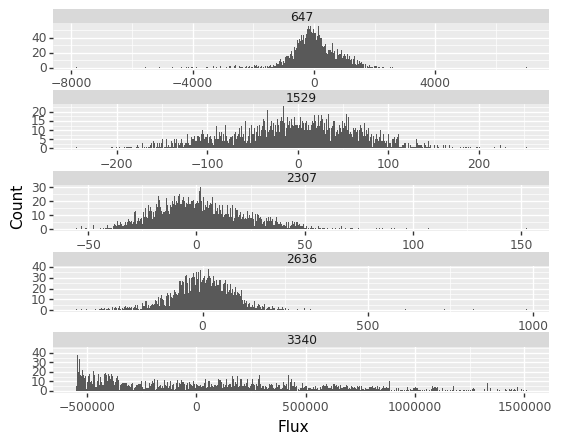

<ggplot: (956185243)>

In [108]:
p9.ggplot(random_training_samples,
  p9.aes(x = 'value', group = 'index')
  ) + \
  p9.theme_gray() + \
  p9.geom_histogram(bins = 672) + \
  p9.ylab('Count') + \
  p9.xlab('Flux') + \
  p9.facet_wrap(facets = '~index', ncol = 1, scales = 'free') + \
  p9.theme(
    legend_title = p9.element_blank(),
    legend_position = 'bottom',
    subplots_adjust = {
      'hspace' : 0.75
    }
  )

##### Stars with exoplanets

Similarly, the same process was applied to stars with exoplanets (label = 2).

In [83]:
random_training_samples_with_exoplanets = train.loc[train['LABEL'] == 2, :].copy() \
  .sample(n = 5) \
  .drop(columns = ['LABEL']) \
  .reset_index(level = 0) \
  .melt(id_vars = ['index'])

random_training_samples_with_exoplanets['index'] = random_training_samples_with_exoplanets['index'].astype('category')
random_training_samples_with_exoplanets['variable'] = pd.to_numeric(random_training_samples_with_exoplanets['variable'].apply(lambda x : re.sub('FLUX\\.', '', x)))

The stars with exoplanets do not seem to significantly differ from the stars without stars. Stars 27 and 34 show some signs of seasonality, but the remaining stars do not. Additionally, star 30 shows a pattern of almost constant dimming in flux, which is very different from any other star plotted so far. 

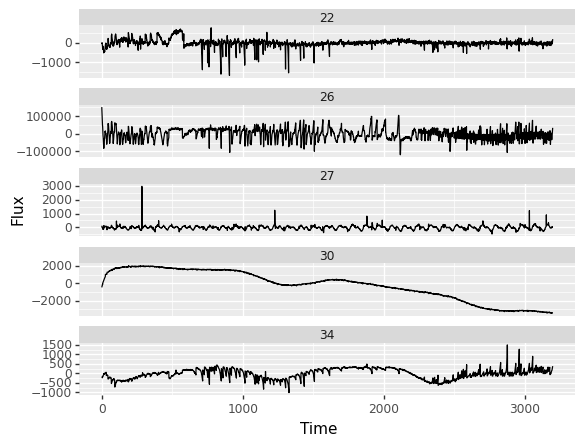

<ggplot: (957472633)>

In [99]:
p9.ggplot(random_training_samples_with_exoplanets,
  p9.aes(x = 'variable', y = 'value', group = 'index')
  ) + \
  p9.theme_gray() + \
  p9.geom_line() + \
  p9.xlab('Time') + \
  p9.ylab('Flux') + \
  p9.facet_wrap(facets = '~index', ncol = 1, scales = 'free_y') + \
  p9.theme(
    legend_title = p9.element_blank(),
    legend_position = 'bottom'
  )

The histogram representations of the flux values of stars 22 and 27 show similar results to the ones seen in stars without exoplanets, i.e., normal like distributions centred around 0 flux. Stars 26 and 34 appear to be characterized by similar distributions, showing a wider range of flux values and negative skewness. Lastly, star 30 shows a more spread out distribution, being defined by three spikes - two major spikes at ±-2600 and ±1750 flux, and a smaller cluster of values close to 0 flux.  
However, still no clear pattern can be defined to differentiate between the classes.

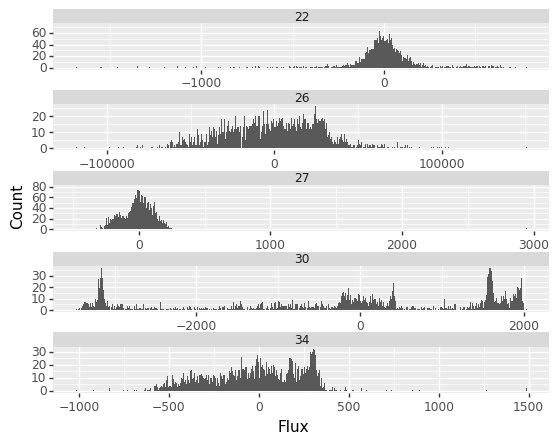

<ggplot: (714202185)>

In [107]:
p9.ggplot(random_training_samples_with_exoplanets,
  p9.aes(x = 'value', group = 'index')
  ) + \
  p9.theme_gray() + \
  p9.geom_histogram(bins = 672) + \
  p9.ylab('Count') + \
  p9.xlab('Flux') + \
  p9.facet_wrap(facets = '~index', ncol = 1, scales = 'free') + \
  p9.theme(
    legend_title = p9.element_blank(),
    legend_position = 'bottom',
    subplots_adjust = {
      'hspace' : 0.75
    }
  )

##### Exploration of flux intensity in the data

Another aspect that is important to study is how the values change over time in a more broad way, instead of looking at five randomly selected rows. Although we can get some information from randmly selected data, it does not give us the full picture, thus, another graphical analysis.

First, we melt the data, i.e., convert the data from multiple columns to a long format of only three columns: index, variable and value.

In [117]:
heatmap_data = pd.concat([train, test]).reset_index(drop = True).reset_index() \
  .melt(id_vars = ['index'])

heatmap_data['index'] = heatmap_data['index'].astype('category')
heatmap_data['variable'] = heatmap_data['variable'].apply(lambda x : re.sub('FLUX\\.', '', x))
heatmap_data.head()

,index,variable,value
0,0,LABEL,2.0
1,1,LABEL,2.0
2,2,LABEL,2.0
3,3,LABEL,2.0
4,4,LABEL,2.0


As we do not want to analyse the label directly, we are going to separate it from the rest of the data before we take care of the heatmap.

In [111]:
label_information = heatmap_data.loc[
  (heatmap_data['variable'] == 'LABEL')
  , :].rename(columns = {'value' : 'label'}) \
  .assign(label = lambda x : x['label'] - 1)[['index', 'label']]
label_information['label'] = label_information['label'].apply(lambda x : bool(x))
label_information.head()

,index,label
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True


We remove the rows referring to the label, convert the timesteps from strings to numbers and rename the columns to ease the analysis.

In [118]:
heatmap_data = heatmap_data.loc[heatmap_data['variable'] != 'LABEL', :]
heatmap_data['variable'] = pd.to_numeric(heatmap_data['variable'])
heatmap_data = heatmap_data.rename(columns = {'variable' : 'timestep'}).reset_index(drop = True)
heatmap_data.head()

,index,timestep,value
0,0,1,93.85
1,1,1,-38.88
2,2,1,532.64
3,3,1,326.52
4,4,1,-1107.21


Now, we add the label information as another column to our dataframe because we want to use this information in the heatmap.

In [119]:
heatmap_data_labeled = pd.merge(heatmap_data, label_information, on = 'index')
heatmap_data_labeled.head()

,index,timestep,value,label
0,0,1,93.85,True
1,0,2,83.81,True
2,0,3,20.10,True
3,0,4,-26.98,True
4,0,5,-39.56,True


As seen below, the heatmap is not informative. This is a direct consequence of the stars, both with and without exoplanets, having a wide range of flux values.

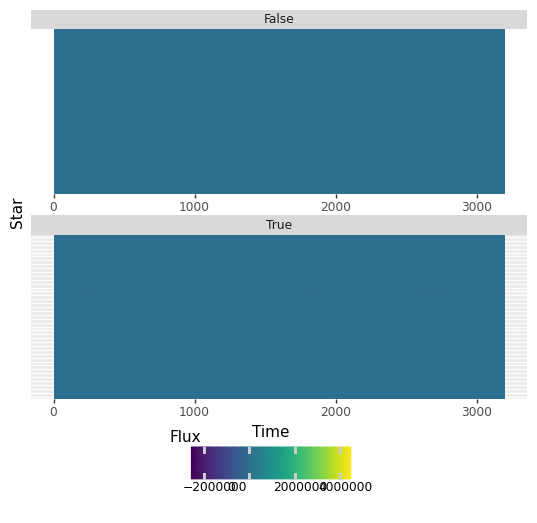

<ggplot: (2128678240)>

In [139]:
p9.ggplot(heatmap_data_labeled,
  p9.aes(x = 'timestep', y = 'index', fill = 'value', group = 'index')
  ) + \
  p9.theme_gray() + \
  p9.geom_tile() + \
  p9.ylab('Star') + \
  p9.xlab('Time') + \
  p9.labs(fill = 'Flux') + \
  p9.facet_wrap(facets = '~label', ncol = 1, scales = 'free') + \
  p9.theme(
    legend_position = 'bottom',
    axis_text_y = p9.element_blank(),
    axis_ticks_major_y = p9.element_blank(),
    axis_ticks_minor_y = p9.element_blank(),
    subplots_adjust = {
      'hspace' : 0.25
    }
  )

Another heatmap was plotted with a small subset of data (5 rows) to confirm that the previous results were correct. Here, with less values, we clearly see that there is a lot of variance between and within rows. It is also visible that some rows tend to be "overshadowed" by rows with wider ranges of values, e.g., first and third rows in the heatmap.   

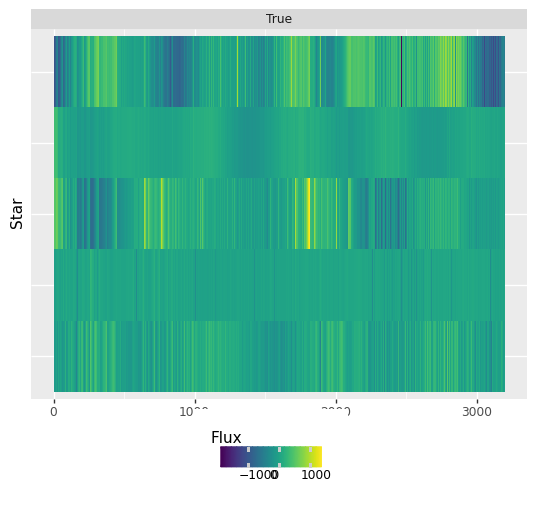

<ggplot: (2128684621)>

In [138]:
p9.ggplot(heatmap_data_labeled.head(3197 * 5),
  p9.aes(x = 'timestep', y = 'index', fill = 'value', group = 'index')
  ) + \
  p9.theme_gray() + \
  p9.geom_tile() + \
  p9.ylab('Star') + \
  p9.xlab('Time') + \
  p9.labs(fill = 'Flux') + \
  p9.facet_wrap(facets = '~label', ncol = 1, scales = 'free') + \
  p9.theme(
    legend_position = 'bottom',
    axis_text_y = p9.element_blank(),
    axis_ticks_major_y = p9.element_blank(),
    axis_ticks_minor_y = p9.element_blank(),
    subplots_adjust = {
      'hspace' : 0.25
    }
  )

As the magnitude of data is too different between stars, which leads to this pattern of very central values in the heatmap (not a lot of colors are visible), the data will be individually normalised following a row-wise normalisation. This is important as we want to understand how the data changes within each star and possible because these are independent from one another. Thus, we use the Min Max Scaler from *sklearn* to do so, transforming the values from their original values to x, where x is in [0, 1].

In [155]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

pivoted_df = heatmap_data_labeled.pivot_table(values = 'value', index = ['index', 'label'], columns = 'timestep')
pivoted_df_scaled = pd.DataFrame(
  # Row-wise normalisation
  scaler.fit_transform(pivoted_df.T).T,
  index = pivoted_df.index, columns = pivoted_df.columns
)
pivoted_df_scaled.head()

,timestep,1,2,3,4,5,6,7,8,9,10,...,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197
index,label,,,,,,,,,,,,,,,,,,,,,
0,True,0.736523,0.730081,0.689200,0.658990,0.650918,0.596280,0.589561,0.614529,0.625039,0.573526,...,0.626207,0.610756,0.610756,0.692428,0.707468,0.735683,0.701533,0.715714,0.679562,0.650931
1,True,0.532753,0.540847,0.501242,0.530814,0.467952,0.478370,0.456348,0.458303,0.460483,0.477457,...,0.589813,0.543444,0.543444,0.555176,0.587280,0.596288,0.576317,0.605424,0.620715,0.627014
2,True,0.654833,0.656359,0.646036,0.638216,0.619388,0.623831,0.623133,0.633317,0.610135,0.632386,...,0.373689,0.413233,0.413233,0.393135,0.397327,0.409395,0.401551,0.393591,0.374466,0.362068
3,True,0.931470,0.964146,0.893628,0.887021,0.917724,0.909832,0.924910,0.907656,0.909394,0.926476,...,0.429184,0.414404,0.414404,0.467293,0.451605,0.400407,0.406513,0.393142,0.393080,0.442132
4,True,0.256688,0.254720,0.252393,0.261119,0.274858,0.283299,0.296523,0.287606,0.299731,0.306570,...,0.444330,0.514840,0.514840,0.531093,0.499437,0.501346,0.515554,0.521064,0.511134,0.475003


The normalised heatmap below gives us much more information than the previous one. We now see how the values chnage ober time. However, we cannot clearly see differences between stars with and without exoplanets, as both classes are characterized by considerable flux changes over time. Nonetheless, it is possible that we may see some transit events on stars with exoplanets in the form of reocurring/seasonal darker shaded points. 

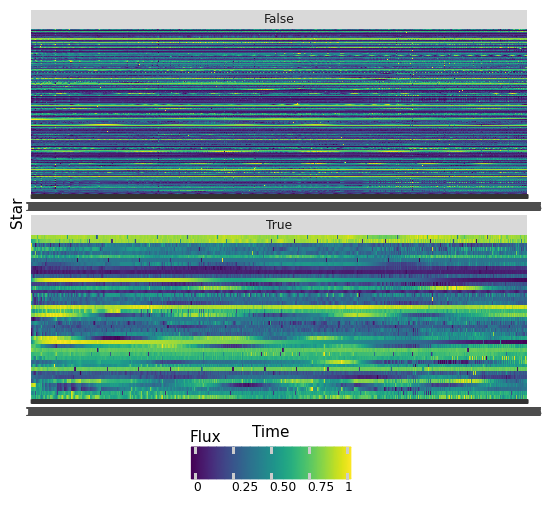

<ggplot: (966357326)>

In [156]:
p9.ggplot(pivoted_df_scaled.reset_index().melt(id_vars = ['index', 'label']),
  p9.aes(x = 'timestep', y = 'index', fill = 'value', group = 'index')
  ) + \
  p9.theme_gray() + \
  p9.geom_tile() + \
  p9.ylab('Star') + \
  p9.xlab('Time') + \
  p9.labs(fill = 'Flux') + \
  p9.facet_wrap(facets = '~label', ncol = 1, scales = 'free') + \
  p9.theme(
    legend_position = 'bottom',
    axis_text_y = p9.element_blank(),
    axis_ticks_major_y = p9.element_blank(),
    axis_ticks_minor_y = p9.element_blank(),
    subplots_adjust = {
      'hspace' : 0.25
    }
  )

### Trend, Seasonality and Heteroscedasticity

Due to the nature of the data, the next is to study presence of trend, seasonal and variance components. To do so, all data will be used. 

In [4]:
all_data = pd.concat([train, test]).reset_index(drop = True).reset_index() \
  .melt(id_vars = ['index'])

all_data['index'] = all_data['index'].astype('category')
all_data['variable'] = all_data['variable'].apply(lambda x : re.sub('FLUX\\.', '', x))
all_data.head()

,index,variable,value
0,0,LABEL,2.0
1,1,LABEL,2.0
2,2,LABEL,2.0
3,3,LABEL,2.0
4,4,LABEL,2.0


We perform some statistical tests in order to evaluate each time series for the desired behaviors. 
* Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests are used to test if the time-series are stationary, i.e., the presence of trend;
  * Test the stationarity for different levels to estimate the number of differences required to make a given time series stationary.
* Osborn, Chui, Smith, and Birchenhall (OCSB) test is used to determine the presence of a seasonal component in the data. As this test requires a value for the seasonal component being tested, multiple values were tested;
  * Test the seasonality for different levels to estimate the number of seasonal differences required to make a given time series stationary.
* White test is used to assess if the variance of data is constant.
  * Returns the p-value of the test: if the p-value is high, we accept the null hypothesis that there is no heteroscedastisticity.

In [5]:
dict_statistical_tests = {}
white_formula = 'value ~ time'
# Iterate over all available data
for index in all_data['index'].unique():
  dict_statistical_tests[index] = {}
  # Get values from row
  series = all_data.loc[
    (all_data['index'] == index) &
    (all_data['variable'] != 'LABEL')
    , :].copy()['value']

  print(index)

  if series.shape[0] > 0:
    # Trend - kpss
    dict_statistical_tests[index]['kpss'] = ndiffs(series, alpha = 0.05, test = 'kpss', max_d = 5)
    # Seasonality - ocbs
    for j in range(10, 1500, 10):
      dict_statistical_tests[index][f'ocsb-{j}'] = nsdiffs(series, test = 'ocsb', m = j, max_D = 5)
    # Heteroskedasticity - white
    white_series = series.reset_index(drop = True).reset_index()
    white_series.columns = ['time', 'value']
    white_series['time'] += 1
    olsr = ols(white_formula, white_series).fit()
    y, X = dmatrices(white_formula, white_series, return_type = 'dataframe')
    _, p_value, _, _ = sms.het_white(olsr.resid, X)
    # As the White test returns a p-value, it was defined that 0.05 would be the cutting point to reject the null hypothesis,
    # i.e., if p-value < 0.05, then the time series is heteroskedastic - the variance is not constant.
    dict_statistical_tests[index]['white'] = 1 if p_value < 0.05 else 0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (757) is shorter than m (1220). Using D=2


127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (977) is shorter than m (1110). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (757) is shorter than m (1220). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (597) is shorter than m (1300). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (537) is shorter than m (1330). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of season

232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (937) is shorter than m (1130). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (757) is shorter than m (1220). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (577) is shorter than m (1310). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (537) is shorter than m (1330). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of season

277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (317) is shorter than m (960). Using D=3
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (167) is shorter than m (1010). Using D=3
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (977) is shorter than m (1110). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (797) is shorter than m (1200). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasona

359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (517) is shorter than m (1340). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (397) is shorter than m (1400). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (257) is shorter than m (1470). Using D=2


559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (537) is shorter than m (1330). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (257) is shorter than m (1470). Using D=2


640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (937) is shorter than m (1130). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (257) is shorter than m (1470). Using D=2


861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (317) is shorter than m (1440). Using D=2


921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136

/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (297) is shorter than m (1450). Using D=2


1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (757) is shorter than m (1220). Using D=2


1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (777) is shorter than m (1210). Using D=2


2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (1057) is shorter than m (1070). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (1037) is shorter than m (1080). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (1017) is shorter than m (1090). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (997) is shorter than m (1100). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of sea

2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (257) is shorter than m (1470). Using D=2


2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (1017) is shorter than m (1090). Using D=2


2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (337) is shorter than m (1430). Using D=2


2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (257) is shorter than m (1470). Using D=2


2817
2818
2819
2820
2821


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (757) is shorter than m (1220). Using D=2


2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (837) is shorter than m (1180). Using D=2


3243
3244
3245
3246
3247
3248
3249
3250


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (337) is shorter than m (1430). Using D=2


3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (257) is shorter than m (1470). Using D=2


4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (957) is shorter than m (1120). Using D=2


4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (877) is shorter than m (1160). Using D=2


4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (417) is shorter than m (1390). Using D=2


4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (497) is shorter than m (1350). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (377) is shorter than m (1410). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (297) is shorter than m (1450). Using D=2


4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (257) is shorter than m (980). Using D=3


4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (837) is shorter than m (1180). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (637) is shorter than m (1280). Using D=2


4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (777) is shorter than m (1210). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (337) is shorter than m (1430). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (297) is shorter than m (1450). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (277) is shorter than m (1460). Using D=2
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of season

4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994


/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (647) is shorter than m (850). Using D=3
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (377) is shorter than m (940). Using D=3
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (287) is shorter than m (970). Using D=3
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (257) is shorter than m (980). Using D=3
/opt/homebrew/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally

4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194


The previously populated dictionary is converted into a dataframe for better visualization and analysis, with the index of each row from the whole data having result values for every performed test.

In [6]:
statistical_test_results = pd.DataFrame.from_dict({
    (i) : dict_statistical_tests[i] 
        for i in dict_statistical_tests.keys() 
    },
    orient = 'index').reset_index()
statistical_test_results.head()

,index,kpss,ocsb-10,ocsb-20,ocsb-30,ocsb-40,ocsb-50,ocsb-60,ocsb-70,ocsb-80,...,ocsb-1410,ocsb-1420,ocsb-1430,ocsb-1440,ocsb-1450,ocsb-1460,ocsb-1470,ocsb-1480,ocsb-1490,white
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


The dataframe is stored in a file for future analysis, if needed.

In [7]:
statistical_test_results.to_csv('../../metrics/statistical_test_results.csv', index = False)

Looking at the results of the tests, it is clear that the mean of the KPSS and White tests are considerable, although these also contain high variance. Despite some signs of seasonality on the previously plots, the tests do not show considerable values for this time series aspect to be dealt with.  

In [8]:
statistical_test_results.describe()

,index,kpss,ocsb-10,ocsb-20,ocsb-30,ocsb-40,ocsb-50,ocsb-60,ocsb-70,ocsb-80,...,ocsb-1410,ocsb-1420,ocsb-1430,ocsb-1440,ocsb-1450,ocsb-1460,ocsb-1470,ocsb-1480,ocsb-1490,white
count,5657.000000,5657.000000,5657.0,5657.0,5657.0,5657.0,5657.0,5657.0,5657.0,5657.0,...,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000
mean,2828.000000,0.651229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000884,0.001237,0.001591,0.000707,0.002121,0.001944,0.004243,0.001768,0.000884,0.631960
std,1633.179568,0.485080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039880,0.044083,0.054801,0.032563,0.062331,0.057927,0.086068,0.053158,0.039880,0.482315
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1414.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2828.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4242.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,5656.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


We want to better understand how these values are distributed. Thus, we first need to get label information alongside the statistical test results.

In [36]:
label_df = all_data.loc[
  (all_data['variable'] == 'LABEL')
  , :].rename(columns = {'value' : 'label'}) \
  .assign(label = lambda x : x['label'] - 1)[['index', 'label']]
label_df['label'] = label_df['label'].apply(lambda x : bool(x))
label_df.head()

,index,label
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True


After creating a dataframe with the labels, we merge the test results with them, as seen below.

In [38]:
statistical_test_results_labeled = pd.merge(label_df, statistical_test_results, on = 'index')
statistical_test_results_labeled.head()

,index,label,kpss,ocsb-10,ocsb-20,ocsb-30,ocsb-40,ocsb-50,ocsb-60,ocsb-70,...,ocsb-1410,ocsb-1420,ocsb-1430,ocsb-1440,ocsb-1450,ocsb-1460,ocsb-1470,ocsb-1480,ocsb-1490,white
0,0,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,True,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,True,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,True,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


##### KPSS Results

Let us first look at the results of the KPSS test. This tests gives us the number of non-seasonal differences that need to be calculated in order to make the data stationary. We see that both data labels (stars with and without exoplanets) have similarly distributed results, i.e., most time-series need first differences to become stationary, followed by a considerable number of already stationary series and, lastly, some data that requires second differences.  

In [47]:
kpss_results = statistical_test_results_labeled[['label', 'kpss']].groupby(by = ['label', 'kpss']).size().to_frame(name = 'count').reset_index()
kpss_results

,label,kpss,count
0,False,0,1985
1,False,1,3609
2,False,2,21
3,True,0,11
4,True,1,29
5,True,2,2


The following plot simplifies the previously mentioned results in a graphical, more direct form. Here, the X axis contains the number of non-seasonal differences, while the Y axis is composed of the number of rows for each bin.

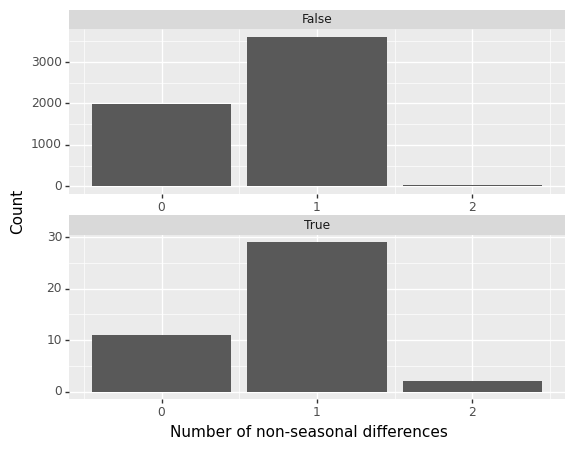

<ggplot: (809475193)>

In [49]:
p9.ggplot(kpss_results,
  p9.aes(x = 'kpss', y = 'count', group = 'kpss')
  ) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity') + \
  p9.ylab('Count') + \
  p9.xlab('Number of non-seasonal differences') + \
  p9.facet_wrap(facets = '~label', ncol = 1, scales = 'free') + \
  p9.theme(
    legend_title = p9.element_blank(),
    legend_position = 'bottom',
    subplots_adjust = {
      'hspace' : 0.25
    }
  )

##### OCSB Results

The analysis of OCSB results gives us an idea on the seasonality component of the data. As transit events are expected to occur every N days, with N changing from star to star, it is expected that some stars show this component. As a result of testing multiple frequency (m) values, the processing of the test results is a bit different, as another variable is now at play. Not only we have label, number of seasonal differences and its count, we also have m. 

The vast majority of time-series do not show any signs of seasonality according to the OCSB test, with only a few showing signs of it as seen below.

In [100]:
ocsb_results = statistical_test_results_labeled[statistical_test_results_labeled.columns[pd.Series(statistical_test_results_labeled.columns).str.startswith(('label', 'ocsb'))]] \
  .melt(id_vars = ['label'])
# Convert strings (ocsb-frequency) to number (frequency)
ocsb_results['variable'] = pd.to_numeric(ocsb_results['variable'].apply(lambda x : x.replace('ocsb-', '')))
# Group by and calculate value counts
ocsb_results = ocsb_results.groupby(by = ['label', 'variable', 'value']).size().to_frame(name = 'count').reset_index()
# Drop all rows where ocsb result was 0 - not important for analysis
ocsb_results = ocsb_results[ocsb_results.value > 0]
# To simplify plot analysis - legend levels
ocsb_results['value'] = ocsb_results['value'].astype('category')
ocsb_results

,label,variable,value,count
10,False,100,1,1
17,False,160,1,1
19,False,170,1,1
27,False,240,1,1
30,False,260,1,1
...,...,...,...,...
288,False,1470,2,9
290,False,1480,1,4
291,False,1480,2,3
293,False,1490,1,1


Due to the low, but still high to be studied with tables, number of interesting results, a plot was created to better analyse the data. We see that there are three different numbers of seasonal differences needed to turn the time-series stationary (1, 2 and 3). Most of these are first or second differences, followed by thir differences in lower numbers. However, the amount of stars that show seasonality according to the test is really low, as seen in the Y axis. In fact, it would be expected that these low numbers would relate to stars with exoplanets, but that is not the case, as only stars without exoplanets showed seasonal signs. Perhaps due to some transit events related to massive gaseous planets, or other celestial bodies.

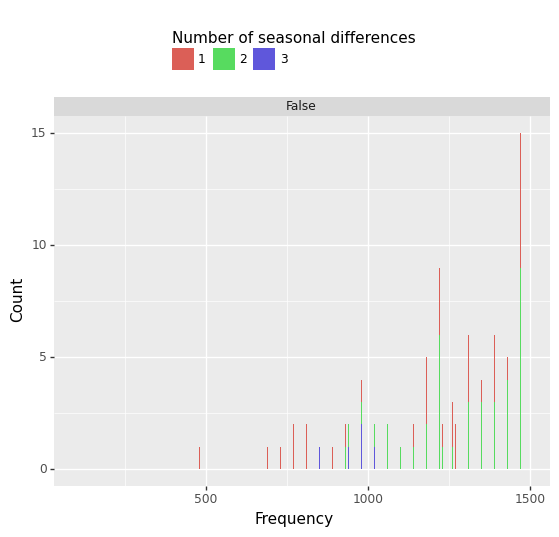

<ggplot: (807047769)>

In [106]:
p9.ggplot(ocsb_results,
  p9.aes(x = 'variable', y = 'count', fill = 'value')
  ) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity') + \
  p9.ylab('Count') + \
  p9.xlab('Time') + \
  p9.facet_wrap(facets = '~label', ncol = 1, scales = 'free') + \
  p9.labs(fill = 'Number of seasonal differences') + \
  p9.theme(
    legend_position = 'top',
    subplots_adjust = {
      'hspace' : 0.25
    }
  )

##### White Results

Lastly, we want to understand if the variance is uniform over time or if it changes. Hence, the application of White test. There are two possible values - 0 if the variance is homogeneous and 1 otherwise. Once more, most time-series in each label show signs of heteroscedasticity (non-homogeneous variance) as seen below.

In [50]:
white_results = statistical_test_results_labeled[['label', 'white']].groupby(by = ['label', 'white']).size().to_frame(name = 'count').reset_index()
white_results

,label,white,count
0,False,0,2070
1,False,1,3545
2,True,0,12
3,True,1,30


By looking at these results graphically, the count difference is clear. However, a large number, especially percentage-wise, of time-series do not show signs of heteroscedasticity according to the White test.

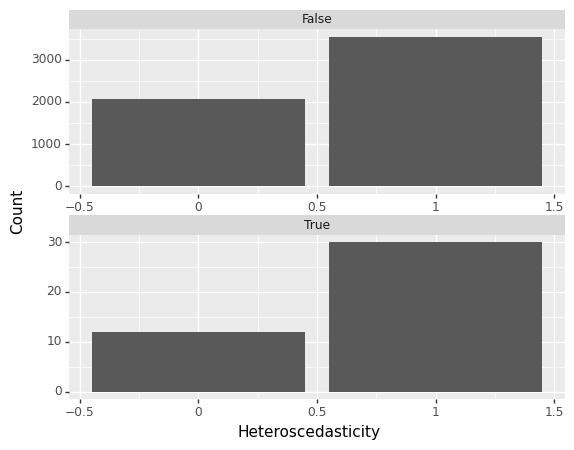

<ggplot: (808228393)>

In [51]:
p9.ggplot(white_results,
  p9.aes(x = 'white', y = 'count', group = 'white')
  ) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity') + \
  p9.ylab('Count') + \
  p9.xlab('Heteroscedasticity') + \
  p9.facet_wrap(facets = '~label', ncol = 1, scales = 'free') + \
  p9.theme(
    legend_title = p9.element_blank(),
    legend_position = 'bottom',
    subplots_adjust = {
      'hspace' : 0.25
    }
  )

This analysis showed that the data set is highly imbalanced. It also showed that there is no clear difference in the distributions and behaviours of stars with and without exoplanets. Additionally, most time series show trend and heteroscedasticity, which could be dealt with by calculating non-seasonal differences and applying the logarithm function to data, respectively.